In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
## NECESSARY UPDATES
# 1 - ONE STEP GAMMA OPT
# 2 - OPT GAMMA TILL CONVERGENCE

## LOOK AT POPULATION PARAMETERS OVER 100 RUNS (SEEDS)

In [2]:
# set rng

rng = np.random.RandomState(1984)

In [3]:
# population effects

intercept = -2.
slope = 2.

pop_coefs = np.array([[intercept, slope]])
pop_coefs.shape

(1, 2)

In [4]:
# subject specific effects

num_subjects = 10000

subj_intercepts = rng.randn(num_subjects)
subj_slopes = rng.randn(num_subjects)

In [5]:
# observed features

n_obs_per_subject = rng.randint(50, 100, size=num_subjects)

sid = np.array([i for i, n_obs in enumerate(n_obs_per_subject) for _ in range(n_obs)]).astype(np.int32)
sid_nobs = np.array([n_obs for i, n_obs in enumerate(n_obs_per_subject) for _ in range(n_obs)]).astype(np.int32)

ss_coefs = np.array([
    [c0, c1]
    for n_obs, c0, c1 in zip(n_obs_per_subject, subj_intercepts, subj_slopes)
    for _ in range(n_obs)
])

X = np.stack([np.ones(len(sid)), rng.randn(len(sid))]).T.astype(np.float32)
X.shape, ss_coefs.shape

((747593, 2), (747593, 2))

In [6]:
# outcomes

y_logits = np.sum(X * pop_coefs + X * ss_coefs, axis=-1)

def sigmoid(z):
    return 1 / (1 + np.exp(-1 * z))

y_probs = sigmoid(y_logits)
y = (rng.rand(len(y_probs)) < y_probs).astype(np.float32)

y.shape

(747593,)

The overall event rate is 0.23820314


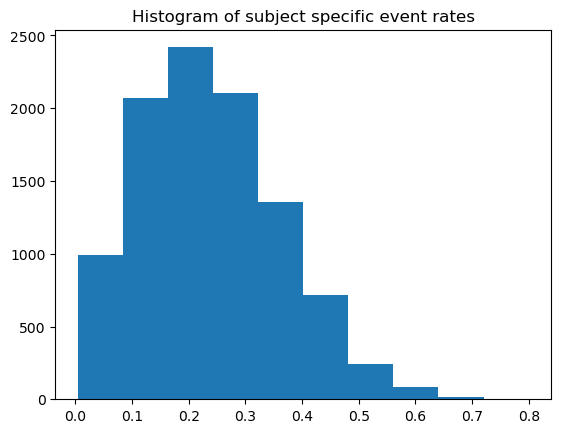

In [7]:
# summary of outcomes

print('The overall event rate is', y.mean())

plt.hist([y_probs[sid == i].mean() for i in range(num_subjects)])
plt.title('Histogram of subject specific event rates')
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
#from torch.utils.data import DataLoader, TensorDataset

# Define the model. Note that 

def normal_nll(x, mu=0., sigma=1.):
    return .5 * ((x - mu) / sigma) ** 2

class NeuralFeaturesGLMM(nn.Module):
    def __init__(self, num_population_effects, num_subjects, num_subject_specific_effects):
        super(NeuralFeaturesGLMM, self).__init__()
        
        self.pop_params_layer = nn.Linear(num_population_effects, 1, bias=False)
        
        self.ss_params_layer = nn.Embedding(num_subjects, num_subject_specific_effects)
        self.ss_params_mu = 0#nn.Parameter(torch.zeros(num_subject_specific_effects, 1))
        self.ss_params_logsigma = nn.Parameter(torch.zeros(num_subject_specific_effects, 1))
        
        self.pop_nll = nn.BCEWithLogitsLoss(reduction='none')
        self.ssp_nll = nn.GaussianNLLLoss(reduction='none')
        
        self.ss_params = self.ss_params_layer.parameters()
        #self.pop_params = (*self.pop_params_layer.parameters(), self.ss_params_mu, self.ss_params_logsigma)
        self.pop_params = (*self.pop_params_layer.parameters(), self.ss_params_logsigma)

    def forward(self, x, z, sid):
        logits = torch.squeeze(self.pop_params_layer(x))
        ss_params = self.ss_params_layer(sid)
        logits += torch.sum(ss_params * z, axis=-1)
        
        return logits
        
    def nll(self, x, z, sid, sid_nobs, y):
        
        y_pred = self.forward(x, z, sid)
        
        # cross entropy loss
        nll = self.pop_nll(y_pred, y)
        
        # subject specific parameters
        ssp = torch.t(self.ss_params_layer(sid))
        
        # subject specific effects likelihood
        # we divide by num obs for each subject to avoid repeating for each observation
        nll += torch.sum(self.ssp_nll(ssp, self.ss_params_mu, torch.exp(2 * self.ss_params_logsigma)), 0) / sid_nobs
        
        return torch.sum(nll)

In [9]:
def get_batches(batch_size=1):
    for ndx in range(0, num_subjects, batch_size):
        idx = (sid >= ndx) & (sid < min(ndx + batch_size, num_subjects))
        yield (torch.from_numpy(arr[idx]) for arr in (X, X, sid, sid_nobs, y))

    
def train(model, epochs, ss_steps=1, pop_steps=1):
    
    ss_opt = optim.Adam(model.ss_params)
    pop_opt = optim.Adam(model.pop_params)
    
    all_loss = []
    
    for epoch in range(epochs):
        
        epoch_loss = []
        
        for batch_idx, (x_batch, z_batch, sid_batch, sid_nobs_batch, y_batch) in enumerate(
            get_batches(batch_size=50)):
            
            #print(x_batch.dtype, sid_batch.dtype, sid_nobs_batch.dtype, y_batch.dtype)
            
            for step in range(ss_steps):
            
                ss_opt.zero_grad()              
                
                loss = model.nll(x_batch, z_batch, sid_batch, sid_nobs_batch, y_batch)
                loss.backward()
                ss_opt.step()
                
            for step in range(pop_steps):
                
                pop_opt.zero_grad()
                
                loss = model.nll(x_batch, z_batch, sid_batch, sid_nobs_batch, y_batch)
                loss.backward()
                pop_opt.step()
                
            current_loss = loss.detach().numpy()
            epoch_loss.append(current_loss)
            
        epoch_loss = np.mean(epoch_loss)
        all_loss.append(epoch_loss)
        print('Epoch %i; Loss = %.3f' % (epoch, epoch_loss))
        
    return all_loss
        
mdl = NeuralFeaturesGLMM(2, num_subjects, 2)

In [10]:
all_loss = train(mdl, 200, ss_steps=1)

Epoch 0; Loss = 2949.781
Epoch 1; Loss = 2706.787
Epoch 2; Loss = 2518.478
Epoch 3; Loss = 2373.865
Epoch 4; Loss = 2262.487
Epoch 5; Loss = 2176.127
Epoch 6; Loss = 2108.574
Epoch 7; Loss = 2055.191
Epoch 8; Loss = 2012.523
Epoch 9; Loss = 1977.988
Epoch 10; Loss = 1949.637
Epoch 11; Loss = 1925.996
Epoch 12; Loss = 1905.935
Epoch 13; Loss = 1888.587
Epoch 14; Loss = 1873.286
Epoch 15; Loss = 1859.517
Epoch 16; Loss = 1846.887
Epoch 17; Loss = 1835.095
Epoch 18; Loss = 1823.918
Epoch 19; Loss = 1813.191
Epoch 20; Loss = 1802.797
Epoch 21; Loss = 1792.655
Epoch 22; Loss = 1782.711
Epoch 23; Loss = 1772.932
Epoch 24; Loss = 1763.297
Epoch 25; Loss = 1753.797
Epoch 26; Loss = 1744.424
Epoch 27; Loss = 1735.177
Epoch 28; Loss = 1726.056
Epoch 29; Loss = 1717.062
Epoch 30; Loss = 1708.194
Epoch 31; Loss = 1699.453
Epoch 32; Loss = 1690.840
Epoch 33; Loss = 1682.356
Epoch 34; Loss = 1674.001
Epoch 35; Loss = 1665.773
Epoch 36; Loss = 1657.674
Epoch 37; Loss = 1649.703
Epoch 38; Loss = 1641.

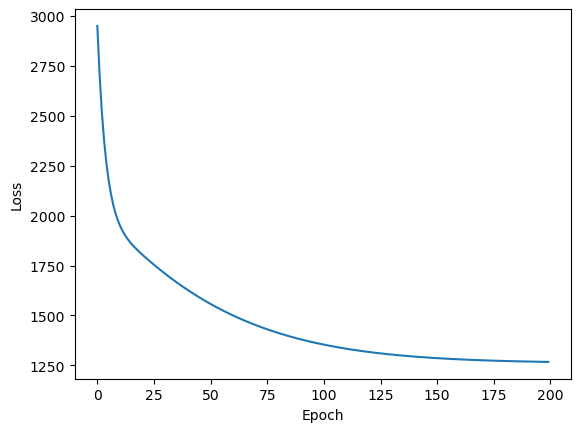

In [11]:
plt.plot(np.arange(len(all_loss)), all_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
for name, param in mdl.named_parameters():
    if param.requires_grad:
        print(name, param.data)

ss_params_logsigma tensor([[-0.2994],
        [-0.4538]])
pop_params_layer.weight tensor([[-1.8055,  1.7506]])
ss_params_layer.weight tensor([[-0.0508, -1.9528],
        [-1.0003, -0.4075],
        [ 1.4247,  1.0305],
        ...,
        [ 1.0567,  0.2588],
        [-0.7640, -0.2249],
        [ 0.6892,  0.7437]])


In [13]:
ss_params_estimated = mdl.ss_params_layer.weight.detach().numpy()

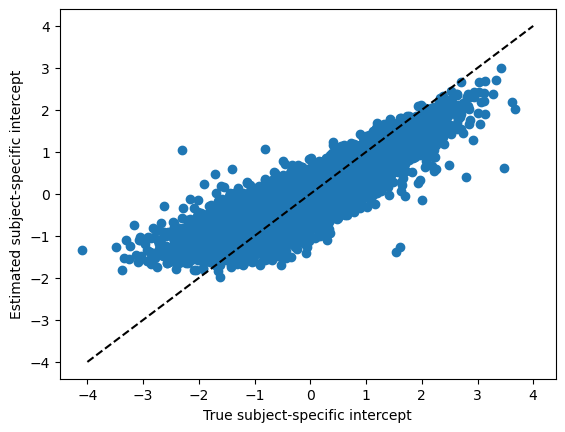

In [14]:
plt.scatter(subj_intercepts, ss_params_estimated[:, 0])
plt.plot([-4, 4], [-4, 4], 'k--')
plt.xlabel('True subject-specific intercept')
plt.ylabel('Estimated subject-specific intercept')
plt.show()

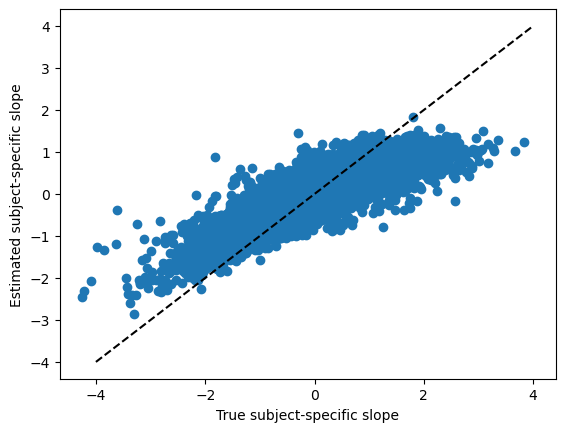

In [15]:
plt.scatter(subj_slopes, ss_params_estimated[:, 1])
plt.plot([-4, 4], [-4, 4], 'k--')
plt.xlabel('True subject-specific slope')
plt.ylabel('Estimated subject-specific slope')
plt.show()